In [97]:
import os
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/aerial-cactus/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')

Running locally


In [98]:
import torch
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import pandas as pd

In [99]:
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [127]:
ANNOTATIONS_FILE = DATA_PATH + 'train.csv'
IMG_DIR = DATA_PATH + 'train/train/'
CHECKPOINT_DIR = '/kaggle/working/checkpoints' if is_running_on_kaggle() else 'checkpoints/'
FIGURES_DIR = '/kaggle/working/figures' if is_running_on_kaggle() else 'figures/'

SEED = 42
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
TRAIN_SPLIT = 0.8
EPOCHS = 100 if is_running_on_kaggle() else 5

In [101]:
torch.manual_seed(42)

In [102]:
from torchvision.io import read_image

class CactusDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [103]:
import torchvision.transforms as transforms

# mean and std of the cactai dataset
mean = [0.5035902857780457, 0.451941579580307, 0.4681771695613861]
std = [0.15118408203125, 0.1397838294506073, 0.15320344269275665]

transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=mean, std=std),
])

In [104]:
# Create the dataset object
trainval_data = CactusDataset(ANNOTATIONS_FILE, IMG_DIR, transform=transform)

# Print the shape of the first image in the dataset
print(trainval_data[0][0].shape)

torch.Size([3, 32, 32])


In [105]:
from torch.utils.data import random_split

# Define the sizes of training and validation sets
train_size = int(TRAIN_SPLIT * len(trainval_data))
val_size = len(trainval_data) - train_size

# Split the dataset into training and validation sets
train_data, val_data = random_split(trainval_data, [train_size, val_size])

# Print the sizes of the training and validation sets
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))

Training set size: 14000
Validation set size: 3500


In [106]:
# Utility function for saving epochs checkpoints
def save_checkpoint(model, optimizer, loss, dir, desc):
    checkpoint_dir = os.path.join(CHECKPOINT_DIR, dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{desc}.pt')
    torch.save({
        'desc': desc,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)

# Utility function for loading epochs checkpoints
def load_checkpoint(model, optimizer, dir, desc):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, dir, f'checkpoint_{desc}.pt')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    return model, optimizer, loss

In [107]:
# Training loop (1 epoch)
def train_model(train_dataloader, model, criterion, optimizer, checkpoint=False, desc='Training', dir_checkpoint=None):
    avg_train_loss = 0
    train_bar = tqdm(train_dataloader, desc=desc, leave=False)
    
    model.train()
    for X, y in train_bar:
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X.float())
        y = y.reshape(-1, 1).float()
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the average loss
        avg_train_loss += loss.item() * len(y)

        # Update the loading bar
        train_bar.set_postfix({'loss': loss.item()})
        
    avg_train_loss = avg_train_loss / len(train_dataloader.dataset)
    train_bar.set_postfix({'loss': avg_train_loss})
    train_bar.close()

    if checkpoint:
        save_checkpoint(model, optimizer, avg_train_loss, dir_checkpoint, desc)

    return avg_train_loss

In [108]:
# Compute validation loss and error rate
def evaluate(val_dataloader, model, criterion, desc='Validation'):
    avg_val_loss = 0
    errors = []
    val_bar = tqdm(val_dataloader, desc=desc, leave=False)

    model.eval()
    with torch.no_grad():
        for X, y in val_bar:
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model(X.float())
            y = y.reshape(-1, 1).float()
            loss = criterion(pred, y)

            # Save errors for error rate
            pred = nn.Sigmoid()(pred) > 0.5
            errors += pred != y

            # Update the average loss
            avg_val_loss += loss.item() * len(y)

            # Update the loading bar
            val_bar.set_postfix({'loss': loss.item()})
    
    avg_val_loss = avg_val_loss / len(val_dataloader.dataset)
    val_bar.set_postfix({'loss': avg_val_loss})
    val_bar.close()
    return avg_val_loss, errors

In [109]:
# Early stopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [110]:
class CustomConvNet(torch.nn.Module):
    def __init__(self, fc_size, dropout):
        super(CustomConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, fc_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc_size, 1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

>>>>>>>>     FC Size: 6 - Dropout: 0.1     <<<<<<<<


Epoch 1/5	 Train Loss: 0.1959 - Val Loss: 0.0879 - Error Rate: 0.0314


Epoch 2/5	 Train Loss: 0.0854 - Val Loss: 0.0558 - Error Rate: 0.0166


Epoch 3/5	 Train Loss: 0.0679 - Val Loss: 0.0503 - Error Rate: 0.0180


Epoch 4/5	 Train Loss: 0.0516 - Val Loss: 0.0363 - Error Rate: 0.0126


Epoch 5/5	 Train Loss: 0.0409 - Val Loss: 0.0307 - Error Rate: 0.0100


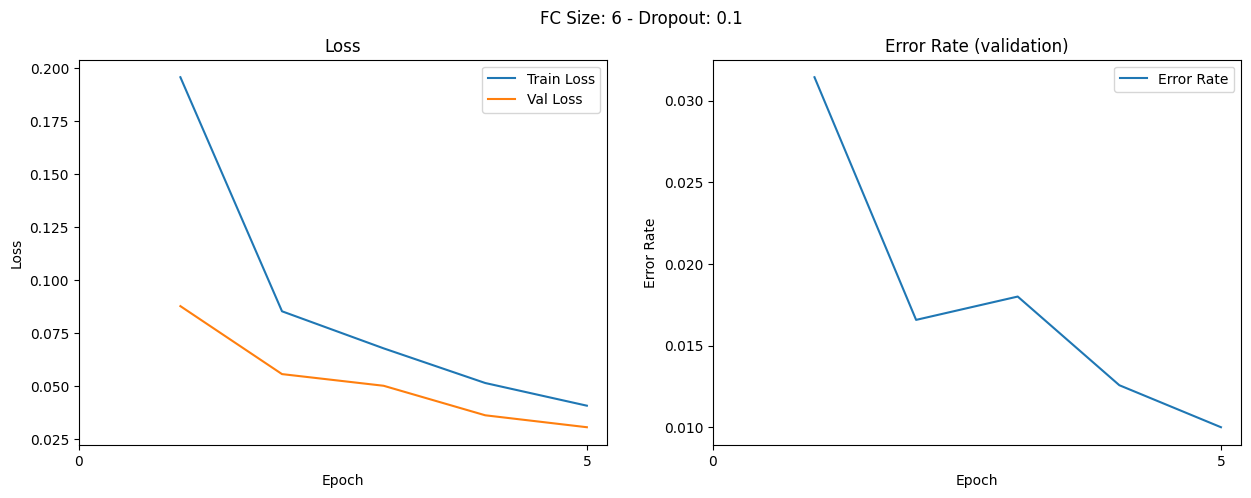

>>>>>>>>     FC Size: 6 - Dropout: 0.3     <<<<<<<<


Epoch 1/5	 Train Loss: 0.6459 - Val Loss: 0.6227 - Error Rate: 0.2377


Epoch 2/5	 Train Loss: 0.6134 - Val Loss: 0.5942 - Error Rate: 0.2377


Epoch 3/5	 Train Loss: 0.5926 - Val Loss: 0.5760 - Error Rate: 0.2377


Epoch 4/5	 Train Loss: 0.5800 - Val Loss: 0.5645 - Error Rate: 0.2377


Epoch 5/5	 Train Loss: 0.5727 - Val Loss: 0.5578 - Error Rate: 0.2377


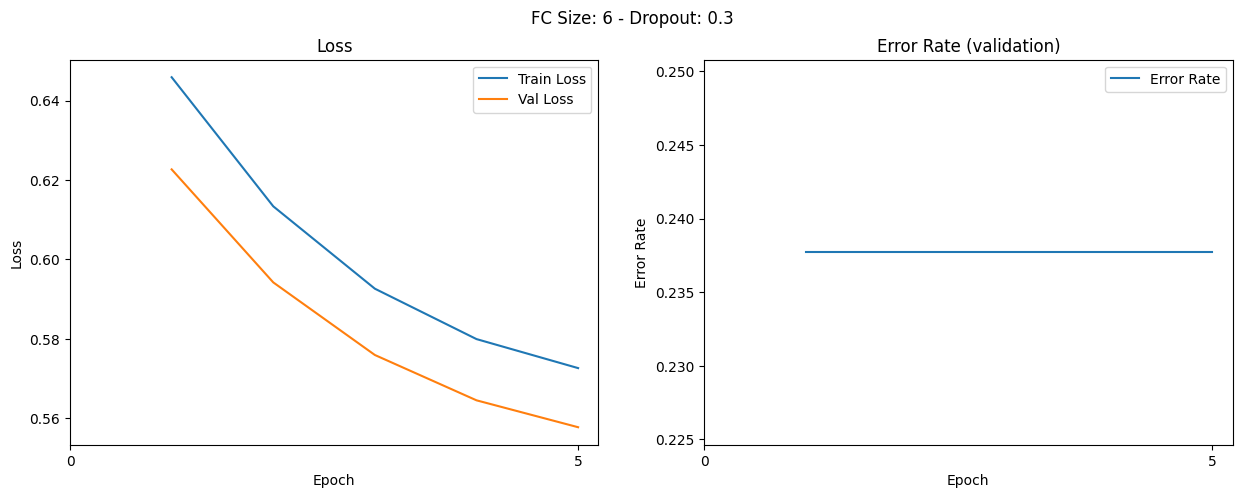

>>>>>>>>     FC Size: 6 - Dropout: 0.5     <<<<<<<<


Epoch 1/5	 Train Loss: 0.3370 - Val Loss: 0.1415 - Error Rate: 0.0446


Epoch 2/5	 Train Loss: 0.2241 - Val Loss: 0.0915 - Error Rate: 0.0277


Epoch 3/5	 Train Loss: 0.1984 - Val Loss: 0.0644 - Error Rate: 0.0154


Epoch 4/5	 Train Loss: 0.2077 - Val Loss: 0.0732 - Error Rate: 0.0186


Epoch 5/5	 Train Loss: 0.1916 - Val Loss: 0.0521 - Error Rate: 0.0140


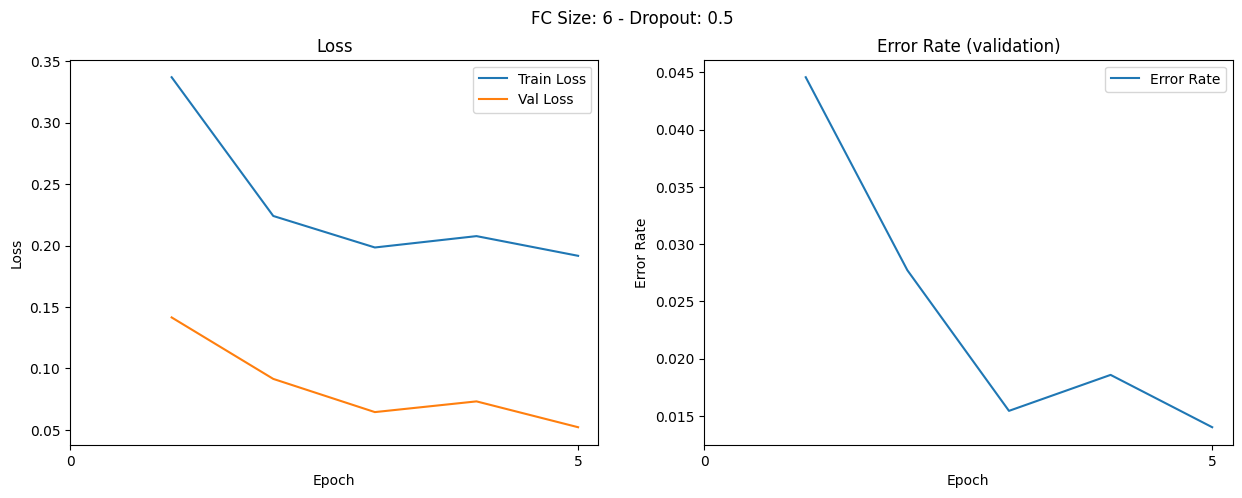

>>>>>>>>     FC Size: 12 - Dropout: 0.1     <<<<<<<<


Epoch 1/5	 Train Loss: 0.5346 - Val Loss: 0.4528 - Error Rate: 0.0406


Epoch 2/5	 Train Loss: 0.4196 - Val Loss: 0.3845 - Error Rate: 0.0306


Epoch 3/5	 Train Loss: 0.3608 - Val Loss: 0.3213 - Error Rate: 0.0191


Epoch 4/5	 Train Loss: 0.3134 - Val Loss: 0.3016 - Error Rate: 0.0317


Epoch 5/5	 Train Loss: 0.2646 - Val Loss: 0.2586 - Error Rate: 0.0200


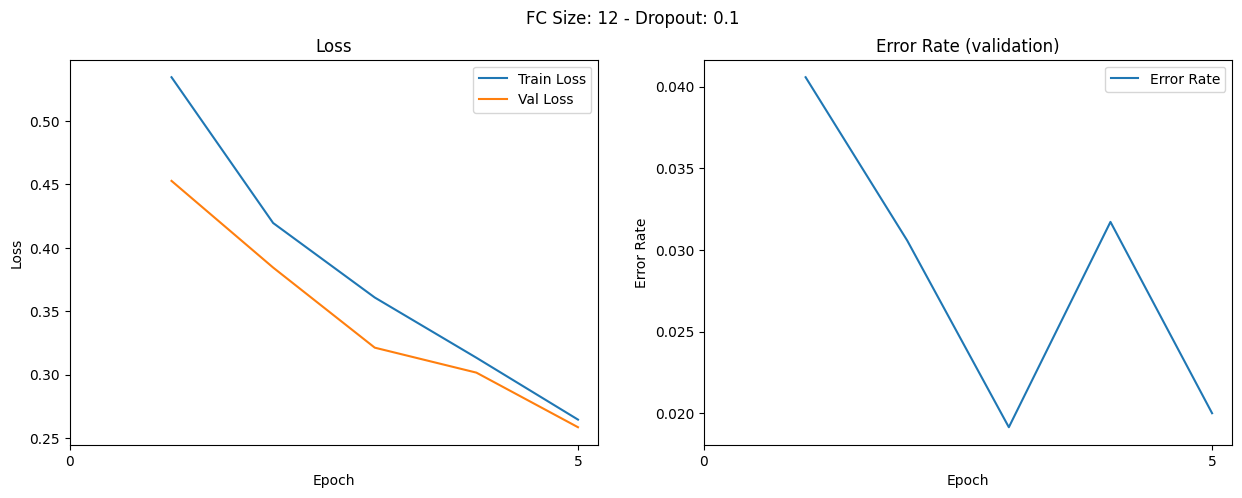

>>>>>>>>     FC Size: 12 - Dropout: 0.3     <<<<<<<<


Epoch 1/5	 Train Loss: 0.2585 - Val Loss: 0.0868 - Error Rate: 0.0303


Epoch 2/5	 Train Loss: 0.1120 - Val Loss: 0.0556 - Error Rate: 0.0180


KeyboardInterrupt: 

In [128]:
fc_sizes = [6, 12, 24]
dropouts = [0.1, 0.3, 0.5]
%matplotlib inline

for fc_size in fc_sizes:
    for dropout in dropouts:
        print(f'>>>>>>>>     FC Size: {fc_size} - Dropout: {dropout}     <<<<<<<<')
        # Create the model
        model = CustomConvNet(fc_size=fc_size, dropout=dropout).to(device)

        # Define the loss function and optimizer
        criterion = nn.BCEWithLogitsLoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # Create the dataloaders
        train_dataloader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_data, BATCH_SIZE, shuffle=False)

        train_losses = []
        val_losses = []
        err_rates = []
        early_stopper = EarlyStopper(patience=10, min_delta=5e-4)

        for epoch in range(EPOCHS):
            train_loss = train_model(train_dataloader, model, criterion, optimizer, checkpoint=True, desc=f'TrainingEpoch{(epoch + 1):02d}', dir_checkpoint=f'custom/fc_{fc_size}_dropout_{dropout}')
            val_loss, errors = evaluate(val_dataloader, model, criterion, desc=f'ValidationEpoch{(epoch + 1):02d}')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            error_rate = (sum(errors) / len(val_data)).item()
            err_rates.append(error_rate)
            print(f'Epoch {epoch + 1}/{EPOCHS}\t Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Error Rate: {error_rate:.4f}')

            if early_stopper.early_stop(val_loss):
                print(f'Early stopping on epoch {epoch + 1}')
                break
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'FC Size: {fc_size} - Dropout: {dropout}')
        
        axs[0].title.set_text('Loss')
        axs[1].title.set_text('Error Rate (validation)')
        
        epochs = [i+1 for i in range(len(train_losses))]
        axs[0].plot(epochs, train_losses, label='Train Loss')
        axs[0].plot(epochs, val_losses, label='Val Loss')
        axs[1].plot(epochs, err_rates, label='Error Rate')
        
        epochs = [i for i in range(0, len(train_losses)+1, 5)]
        axs[0].set_xlabel('Epoch')
        axs[0].set_xticks(epochs)
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[1].set_xlabel('Epoch')
        axs[1].set_xticks(epochs)
        axs[1].set_ylabel('Error Rate')
        axs[1].legend()        

        plt.show()
        fig_dir = os.path.join(FIGURES_DIR, f'custom')
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        fig_path = os.path.join(fig_dir, f'fc_{fc_size}_dropout_{dropout}.png')
        
        fig.savefig(fig_path)